---
layout: post  
title: Assembling the smallest genome in refseq  
date: 2020-10-01  
author: Cameron Prybol  

---

In [36]:
import Pkg
pkgs = [
    "BioSequences",
    "BioServices",
    "Dates",
    "HTTP",
    "uCSV",
    "DataFrames",
    "CodecZlib",
    "StatsBase",
    "FASTX",
    "Revise",
    "StatsPlots"
]
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

Eisenia_path = "$(homedir())/git/Eisenia"
# this will ensure that LocusJulia can load and all dependencies are installed
push!(LOAD_PATH, Eisenia_path); Pkg.activate(Eisenia_path); Pkg.update(); Pkg.instantiate(); Pkg.activate()
import Eisenia

 Resolving package versions...
 Installed FixedPointNumbers ─── v0.8.4
 Installed ColorTypes ────────── v0.10.9
 Installed StatsPlots ────────── v0.14.13
 Installed FFTW ──────────────── v1.1.0
 Installed DocStringExtensions ─ v0.8.3
 Installed Arpack ────────────── v0.3.2
 Installed KernelDensity ─────── v0.6.0
 Installed AbstractFFTs ──────── v0.5.0
 Installed AxisAlgorithms ────── v1.0.0
 Installed Interpolations ────── v0.12.10
 Installed WoodburyMatrices ──── v0.5.2
 Installed Distances ─────────── v0.9.1
 Installed PlotUtils ─────────── v1.0.7
 Installed Colors ────────────── v0.12.4
 Installed PlotThemes ────────── v2.0.0
 Installed Ratios ────────────── v0.4.0
 Installed Widgets ───────────── v0.6.2
 Installed GR ────────────────── v0.50.1
 Installed Observables ───────── v0.3.1
 Installed TableOperations ───── v0.2.1
 Installed Clustering ────────── v0.14.1
 Installed NearestNeighbors ──── v0.4.6
 Installed DataValues ────────── v0.4.13
 Installed MultivariateStats ─── v0.7.0


┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1192


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/git/Eisenia/Project.toml`
 [no changes]
  Updating `~/git/Eisenia/Manifest.toml`
 [no changes]
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
TODAY=string(Dates.today())
TODAY="2020-10-01"
TASK = "refseq-assembly-1"
DIR = "$(homedir())/$(TODAY)-$(TASK)"
if !isdir(DIR)
    mkdir(DIR)
end
cd(DIR)

In [3]:
# download the assembly summary report for refseq
refseq_assembly_summary_url = "https://ftp.ncbi.nlm.nih.gov/genomes/refseq/assembly_summary_refseq.txt"
response = HTTP.request("GET", refseq_assembly_summary_url).body
# skip header comments
filtered_response_buffer = IOBuffer(join(readlines(IOBuffer(response))[2:end], '\n'))
data, header = uCSV.read(filtered_response_buffer, delim='\t', header=1)
header[1] = replace(header[1], r"#\s+" => "")
assembly_summary_refseq_table = DataFrames.DataFrame(data, header)

# we want the genome sizes so that we can work from small to large
species_genome_sizes_url = "ftp://ftp.ncbi.nlm.nih.gov/genomes/ASSEMBLY_REPORTS/species_genome_size.txt.gz"
response = HTTP.request("GET", species_genome_sizes_url).body
data, header = uCSV.read(CodecZlib.GzipDecompressorStream(IOBuffer(response)), delim='\t', header=1)
header[1] = replace(header[1], "#" => "")
species_genome_size_table = DataFrames.DataFrame(data, header)

# join the files so that we can sort by small to large
assembly_summary_refseq_table = DataFrames.innerjoin(assembly_summary_refseq_table, species_genome_size_table, on="species_taxid")

# sort by genome size
sort!(assembly_summary_refseq_table, "expected_ungapped_length")

,assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid
,String,String,String,String,String,Int64
1,GCF_002829805.1,PRJNA485481,,,na,230604
2,GCF_003972145.1,PRJNA485481,,,na,230604
3,GCF_003972165.1,PRJNA485481,,,na,230604
4,GCF_003972185.1,PRJNA485481,,,na,230604
5,GCF_003972205.1,PRJNA485481,,,na,230604
6,GCF_003972225.1,PRJNA485481,,,na,230604
7,GCF_003972245.1,PRJNA485481,,,na,230604
8,GCF_003972265.1,PRJNA485481,,,na,230604
9,GCF_000851485.1,PRJNA485481,,,reference genome,154834


In [4]:
# task for today, assemble the first genome in the first group
group = DataFrames.groupby(assembly_summary_refseq_table, "species_taxid")[1]

,assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid
,String,String,String,String,String,Int64
1,GCF_002829805.1,PRJNA485481,,,na,230604
2,GCF_003972145.1,PRJNA485481,,,na,230604
3,GCF_003972165.1,PRJNA485481,,,na,230604
4,GCF_003972185.1,PRJNA485481,,,na,230604
5,GCF_003972205.1,PRJNA485481,,,na,230604
6,GCF_003972225.1,PRJNA485481,,,na,230604
7,GCF_003972245.1,PRJNA485481,,,na,230604
8,GCF_003972265.1,PRJNA485481,,,na,230604


In [5]:
target = group[1, :]
show(target, allcols=true)

DataFrameRow
│ Row │ assembly_accession │ bioproject  │ biosample │ wgs_master │
│     │ String             │ String      │ String    │ String     │
├─────┼────────────────────┼─────────────┼───────────┼────────────┤
│ 1   │ GCF_002829805.1    │ PRJNA485481 │           │            │

│ Row │ refseq_category │ taxid  │ species_taxid │ organism_name     │
│     │ String          │ Int64  │ Int64         │ String            │
├─────┼─────────────────┼────────┼───────────────┼───────────────────┤
│ 1   │ na              │ 230604 │ 1922242       │ Extra small virus │

│ Row │ infraspecific_name │ isolate │ version_status │ assembly_level │
│     │ String             │ String  │ String         │ String         │
├─────┼────────────────────┼─────────┼────────────────┼────────────────┤
│ 1   │                    │         │ latest         │ Chromosome     │

│ Row │ release_type │ genome_rep │ seq_rel_date │ asm_name    │ submitter │
│     │ String       │ String     │ String       │ String  

In [6]:
fasta_url = target["ftp_path"] * "/" * basename(target["ftp_path"]) * "_genomic.fna.gz"
fasta = collect(FASTX.FASTA.Reader(CodecZlib.GzipDecompressorStream(IOBuffer(HTTP.request("GET", fasta_url).body))))
@assert length(fasta) == 1
fasta_record = first(fasta)

1-element Array{FASTX.FASTA.Record,1}:
 FASTX.FASTA.Record:
   identifier: NC_043197.1
  description: Macrobrachium rosenbergii XSV virus capsid protein gene, complete cds
     sequence: CCACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGTA…

In [7]:
# simulate reads
reads = FASTX.FASTA.Record[]
coverage = 10
error_rate = 0.1
for i in 1:coverage
    push!(reads, Eisenia.observe(fasta_record, error_rate=error_rate))
end
reads

10

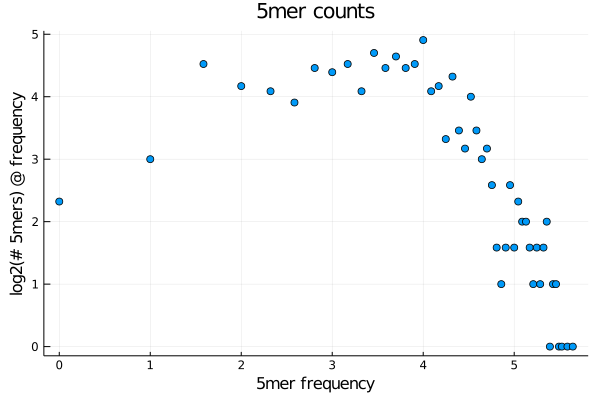

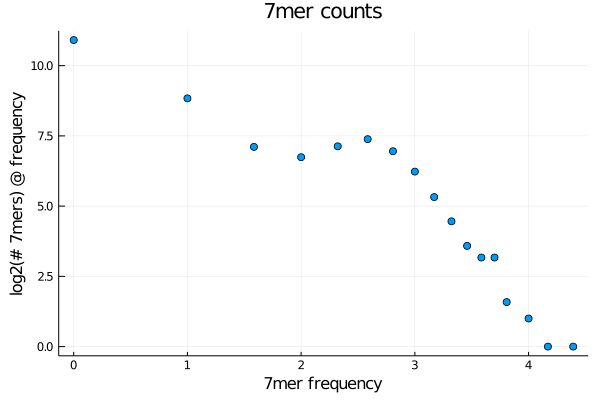

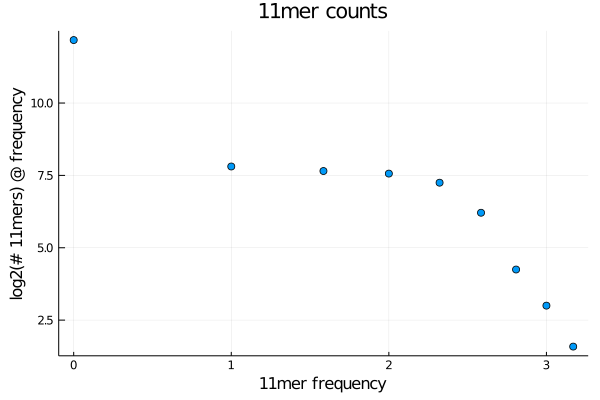

In [47]:
# perform kmer-spectra decomposition at 5, 7, 11
for k in [5, 7, 11]
    kmer_counts = Eisenia.count_canonical_kmers(reads, k)
    histogram_values = sort(collect(StatsBase.countmap(last.(kmer_counts))))
    X = log2.(first.(histogram_values))
    Y = log2.(last.(histogram_values))
    p = StatsPlots.scatter(
        X,
        Y,
        title="$(k)mer counts",
        xlabel="$(k)mer frequency",
        ylabel="log2(# $(k)mers) @ frequency",
        legend=false
    )
    display(p)
end

In [53]:
# find the smallest kmer spectra deomposition of interest

# in the above we can see that the 7mer spectra has a clear signal peak that arises out of the error profile
# so let's try and work with that

0.14285714285714285

In [ ]:
# assemble the genome at the kmer spectra of interest

In [ ]:
# perform error correction